<a href="https://colab.research.google.com/github/BrianThomasRoss/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Brian_Ross_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
import numpy as np
import plotly.express as px
import category_encoders as ce
from math import factorial
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from  sklearn.preprocessing import StandardScaler, scale

#### Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million

In [0]:
building_class_filter = df['BUILDING_CLASS_CATEGORY'] == "01 ONE FAMILY DWELLINGS"
sale_price_filter = (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)

df = df.loc[building_class_filter]
df = df.loc[sale_price_filter]

#### Cleaning

In [0]:
df.drop(columns=['BUILDING_CLASS_CATEGORY', 'APARTMENT_NUMBER'], inplace=True)    #   Dropping zero-variance features

In [0]:
df['LAND_SQUARE_FEET'] = (df['LAND_SQUARE_FEET'].str.replace(",", "")).astype(int)

In [0]:
df['EASE-MENT'] = df['EASE-MENT'].fillna(0)

#### Train / Test Split

In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

cutoff = pd.to_datetime("2019-04-01")

train = df[df.SALE_DATE < cutoff]
test = df[df.SALE_DATE >= cutoff]

assert len(df) == len(train) + len(test)

#### Do one-hot encoding of categorical features.

In [136]:
categorical_cols = train.select_dtypes(exclude='number').columns
numerical_cols = train.select_dtypes(include='number').columns 

for col in categorical_cols:
  print(train[col].value_counts())
  print("\n" + "~~"*20 + "\n")

4    1204
5     662
3     398
2     242
1       1
Name: BOROUGH, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

OTHER                 2382
FLUSHING-NORTH          77
FOREST HILLS            17
BOROUGH PARK            12
ASTORIA                 11
BEDFORD STUYVESANT       8
Name: NEIGHBORHOOD, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1     2476
1D      31
Name: TAX_CLASS_AT_PRESENT, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

A1    919
A5    779
A2    411
A9    193
A0     67
S1     39
A3     38
A8     31
A6     14
A4     13
S0      1
B2      1
B3      1
Name: BUILDING_CLASS_AT_PRESENT, dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

104-18 187TH STREET       2
294 FREEBORN STREET       2
125-27 LUCAS STREET       2
22-40 93RD STREET         2
118-20 202ND STREET       2
                         ..
3 MONTVALE PLACE          1
156-47 89TH STREET        1
137-31 THURSTON STREET    1
97-15 107TH STREET        1
194-11 112TH AVENUE       1
Name: AD

In [0]:
target = 'SALE_PRICE'

high_cardinality_cols = ['ADDRESS',
                         'SALE_DATE']

features = train.columns.drop([target] + high_cardinality_cols)

#   Train
X_train = train[features]
y_train = train[target]

#   Test
X_test = test[features]
y_test = test[target]


In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [139]:
X_test_encoded.head(1)

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
18235,0,0,1,0,0,1,0,0,0,0,0,1,0,5913,878,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,10471.0,1.0,0.0,1.0,5000,2272.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0


#### Feature Selection with SelectKBest

In [153]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

k_list = []
mae_list = []

for k in range(1, len(X_train_encoded.columns)+1):
  if k == 1:
    print(f"With {k} feature:")
  else:
    print(f"With {k} features:")

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train_encoded, y_train)
  X_test_selected = selector.transform(X_test_encoded)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)

  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)

  k_list.append(k)
  mae_list.append(mae)

  print(f"Test MAE: ${mae:,.0f} \n")

With 1 feature:
Test MAE: $183,641 

With 2 features:
Test MAE: $179,555 

With 3 features:
Test MAE: $179,291 

With 4 features:
Test MAE: $179,291 

With 5 features:
Test MAE: $170,483 

With 6 features:
Test MAE: $169,982 

With 7 features:
Test MAE: $168,140 

With 8 features:
Test MAE: $168,245 

With 9 features:
Test MAE: $167,855 

With 10 features:
Test MAE: $164,737 

With 11 features:
Test MAE: $165,346 

With 12 features:
Test MAE: $164,860 

With 13 features:
Test MAE: $155,159 

With 14 features:
Test MAE: $156,541 

With 15 features:
Test MAE: $156,572 

With 16 features:
Test MAE: $156,573 

With 17 features:
Test MAE: $156,394 

With 18 features:
Test MAE: $156,394 

With 19 features:
Test MAE: $156,255 

With 20 features:
Test MAE: $156,255 

With 21 features:
Test MAE: $154,396 

With 22 features:
Test MAE: $154,426 

With 23 features:
Test MAE: $154,426 

With 24 features:
Test MAE: $154,426 

With 25 features:
Test MAE: $154,426 

With 26 features:
Test MAE: $154,12

In [0]:
### Looks like 13 features is within reasonable range of lowest test score 
### with the least amount of features so let's go with that

selector = SelectKBest(score_func=f_regression, k=13)
X_train_selected = selector.fit_transform(X_train_encoded, y_train)
X_test_selected = selector.transform(X_test_encoded)

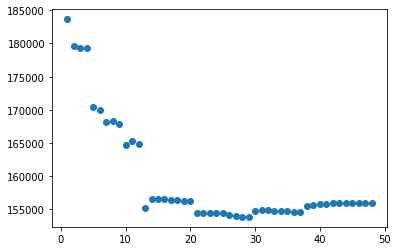

In [148]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(k_list, mae_list);

#### Feature Scaling & Ridge Regression

In [0]:

from IPython.display import display, HTML
from ipywidgets import interact

def analyze_optimum_alpha(train_df, test_df, train_targ, test_targ):

  for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8]:
    # Feature Scaling
    og_train_df = train_df
    scaler = StandardScaler()
    train_df_scaled = scaler.fit_transform(train_df)
    test_df_scaled = scaler.transform(test_df)

    # Fit model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(train_df_scaled, train_targ)

    # Train MAE
    y_pred = model.predict(train_df_scaled)
    mae = mean_absolute_error(train_targ, y_pred)
    display(HTML(f'Train MAE: {mae:,.0f}'))

    # Test MAE
    y_pred = model.predict(test_df_scaled)
    mae = mean_absolute_error(test_targ, y_pred)
    display(HTML(f'Test MAE: {mae:,.0f}'))

    # Plot coeffs
    coefficients = pd.Series(model.coef_, og_train_df.columns)
    plt.figure(figsize=(4,4))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-100000, 100000)
    plt.show()

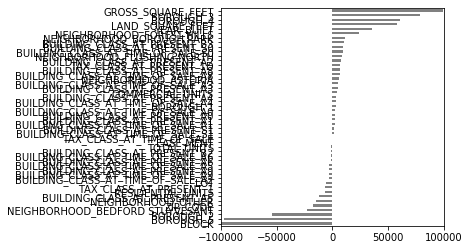

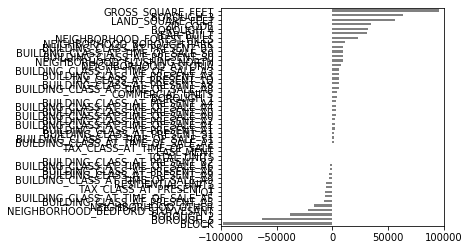

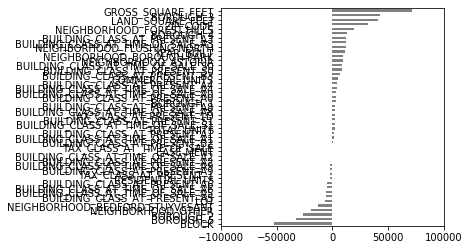

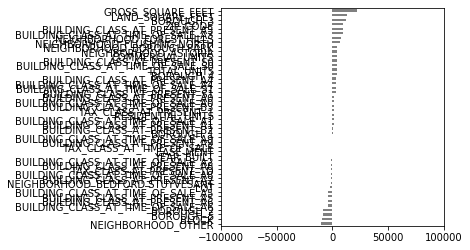

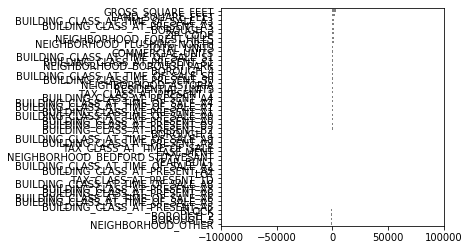

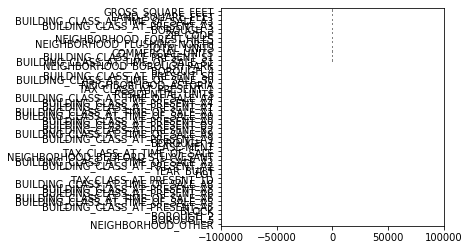

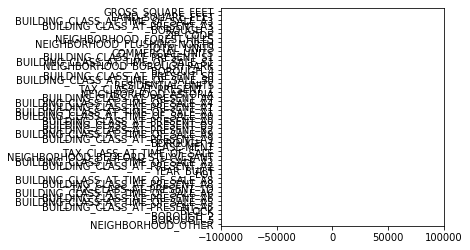

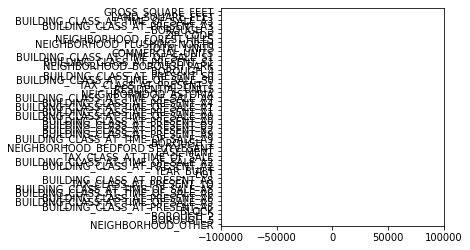

In [169]:
analyze_optimum_alpha(X_train_encoded, X_test_encoded, y_train, y_test)

#### Los otra technica

In [0]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_selected, y_train)
X_test_scaled = scaler.transform(X_test_selected)

In [197]:
model = Ridge(100)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mae

print(f"Test MAE: ${mae:,.0f}")

Test MAE: $155,379


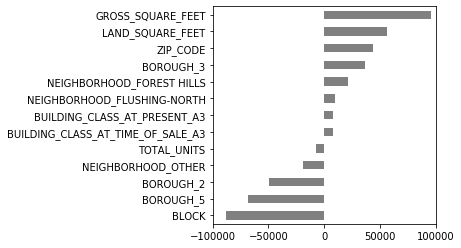

In [208]:
new_features = X_train_encoded.columns[selector.get_support()]

display(HTML(f"Test Error: ${mae:,.0f}"))
coefficients = pd.Series(model.coef_, new_features)
plt.figure(figsize=(4,4))
coefficients.sort_values().plot.barh(color='grey')
plt.xlim(-100000, 100000)
plt.show()